In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

(sample-uniform)=
# Sampling the uniform distribution

If we have a PRNG that samples between zero and a big integer, say $m$, we can create a generator that samples from the uniform distribution.
If $d$ is the sample from the PRNG, then

$$
x = \frac{d}{m},
$$

is approximately uniformly distributed.
Let's experiment with this idea.

We are going to need some of the code we developed in the previous section:

In [4]:
MAX_INT = 6012119

def lcg(
    x : int,
    a : int = 123456,
    b : int = 978564,
    m : int = MAX_INT
):
    """Sample random numbers using a linear congruential generator.
    
    Arguments:
        x     -   The previous number in the sequence.
        a     -   A big integer.
        b     -   Another big integer.
        m     -   Another big integer.
    """
    return (a * x + b) % m

First, let's make a random generator based on LCG:

In [5]:
LCG_STATE = 123456

def unif_lcg():
    """Sample from the uniform using LCG."""
    global LCG_STATE
    LCG_STATE = lcg(LCG_STATE)
    return LCG_STATE / MAX_INT

Let's try it:

In [6]:
print("LCG Uniform Samples:")
for i in range(5):
    u = unif_lcg()
    print(f"sample {i} = {u:.2f}")

LCG Uniform Samples:
sample 0 = 0.27
sample 1 = 0.93
sample 2 = 0.33
sample 3 = 0.10
sample 4 = 0.59


And let's also do it with Mersenne-Twister from numpy:

In [7]:
import numpy as np
np.random.seed(123456)
def unif_mt():
    """Sample from the uniform using the MT."""
    return np.random.randint(0, MAX_INT) / MAX_INT

Let's test this as well:

In [8]:
print("MT Uniform Samples:")
for i in range(5):
    u = unif_mt()
    print(f"sample {i} = {u:.2f}")

MT Uniform Samples:
sample 0 = 0.01
sample 1 = 0.89
sample 2 = 0.51
sample 3 = 0.53
sample 4 = 0.54


Which one of the two is better? There are many statistical tests that we would like our uniform random number generator to go through. First (and most importantly) the empirical histograms of the generated numbers should be uniform. Let's test this.

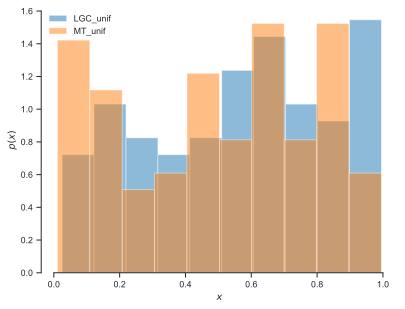

In [9]:
N = 100
# Some LCG-based uniform samples:
lcg_X = np.array(
    [unif_lcg() for _ in range(N)]
)
# Some MT-based uniform samples:
mt_X = np.array(
    [unif_mt() for _ in range(N)]
)

fig, ax = plt.subplots()
ax.hist(
    lcg_X,
    density=True,
    alpha=0.5,
    label="LGC_unif"
)
ax.hist(
    mt_X,
    density=True,
    alpha=0.5,
    label="MT_unif"
)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$p(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

This was a rough visual test.
We can do better.
We can compare the [empirical CDF](https://en.wikipedia.org/wiki/Empirical_distribution_function) of each one of these algorithms with the ideal CDF, i.e., that of an actual uniform.
But what is the empirical CDF of a bunch of samples $x_{1:N}$?
It is defined as follows:

$$
\bar{F}_N(x) = \frac{\text{number of elements in sample}\;\le x}{N} = \frac{1}{N}\sum_{n=1}^N 1_{(-\infty, x_i]}(x).
$$

We will explain in what sense the empirical CDF approximates the actual PDF in [Lecture 9](empirical-cdf).
For now, let's use it:

In [10]:
def ecdf(x):
    """The empirical distribution function of scalar samples.
    
    From: https://stackoverflow.com/questions/15792552/numpy-scipy-equivalent-of-r-ecdfxx-function
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs)+1)/float(len(xs))
    return xs, ys

Now, let's plot the empirical CDF of each of the samples and plot it against $F(x) = x$ (the true CDF of the uniform).

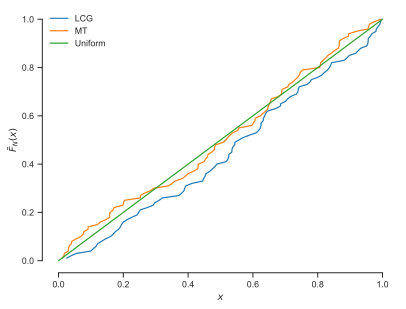

In [11]:
fig, ax = plt.subplots()
ax.plot(*ecdf(lcg_X), label="LCG")
ax.plot(*ecdf(mt_X), label="MT")
ax.plot(np.linspace(0, 1), np.linspace(0, 1), label='Uniform')
ax.set_xlabel("$x$")
ax.set_ylabel("$\\bar{F}_N(x)$")
plt.legend(loc="best", frameon=False)
sns.despine(trim=True);

This is still visual. The [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) summarizes calculate a distance between the empirical distribution and the ideal one.
It is defined as follows:

$$
D_N = \sup_x |F(x) - \hat{F}_N(x)|,
$$

where (if you don't know what it is) you can think of the supremum ($\sup$) as just the maximum.
In other words, $D_N$ is the maximum absolute difference between $F(x)$ and $\hat{F}_N(x)$.
Let's see what we get for LCG and MT compared to the uniform:

In [12]:
import scipy.stats as st
D_lcg, p_val_lcg = st.kstest(lcg_X, "uniform")
D_mt, p_val_mt = st.kstest(mt_X, "uniform")
print(f"KS statistic for LCG vs uniform: {D_lcg:.2f}")
print(f"KS statistic for MT vs uniform: {D_mt:1.2f}")

KS statistic for LCG vs uniform: 0.13
KS statistic for MT vs uniform: 0.06


## Questions
+ Hmm, we need to increase the number of samples to observe this statistic better. Increase $N$ from 100 to $1,000$ and then to $10,000$. What do the distributions look like now?

+ A second thing we want to test is whether or not consecutive numbers are all independent (independently identically distributed). Unfortunately, we need more theory than we know to do this.

+ For future reference, note that you should not use ``unif_mt`` to generate uniform random numbers. Numpy already implements this in ``numpy.random.rand``. We provide an example right below. 

In [13]:
# Generate some random numbers with numpy's unif_mt:
X = np.random.rand(10)
print(X)

[0.15584706 0.86260898 0.6830463  0.0857089  0.56610253 0.14982485
 0.47745445 0.84893827 0.14014442 0.32955081]
